# Gauss–Newton approach / Newton–Raphson approach to minimize the sum of squared errors between model predictions and observed counts

In [1]:
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import misc
from sympy import *
from tabulate import tabulate
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import seaborn as sns
from numpy import linalg as LA
import pandas as pd 
import matplotlib.pyplot as plt  
import functools as fts
from tabulate import tabulate as tabulate
from scipy.stats import norm
from scipy.optimize import fmin
from scipy.stats import *

# 1. Problem 2.6 on page 56 of the Computation Statistics book.

2.6. Table 2.3 provides counts of a ﬂour beetle (Tribolium confusum) population at various points in time [103]. Beetles in all stages of development were counted, and the food supply was carefully controlled. An elementary model for population growth is the logistic model given by

\begin{equation*}
\frac{dN}{dt}=r N(1-\frac{N}{K})
\end{equation*} 

where $N$ ispopulationsize, $t$ is time, $r$ isagrowthrateparameter,and $K$ isaparameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by

\begin{equation*}
N_t=f(t)=\frac{K N_0}{N_0+(K-N)exp(-rt)}
\end{equation*} 

where $N_t$ denotes the population size at time $t$. 

## a. Fit the logistic growth model to the ﬂour beetle data using the Gauss–Newton approach to minimize the sum of squared errors between model predictions and observed counts. 

Table 2.3 is:

In [2]:
df = {'Days':[0,8,28,41,63,79,97,117,135,154],
        'Beetles':[2,47,192,256,768,896,1120,896,1184,1024]}
Data = pd.DataFrame(df)
Data

,Days,Beetles
0,0,2
1,8,47
2,28,192
3,41,256
4,63,768
5,79,896
6,97,1120
7,117,896
8,135,1184
9,154,1024


We can plot the points:

Text(0.5, 1.0, 'Counts of flour beetles in all stages of development over 154 days')

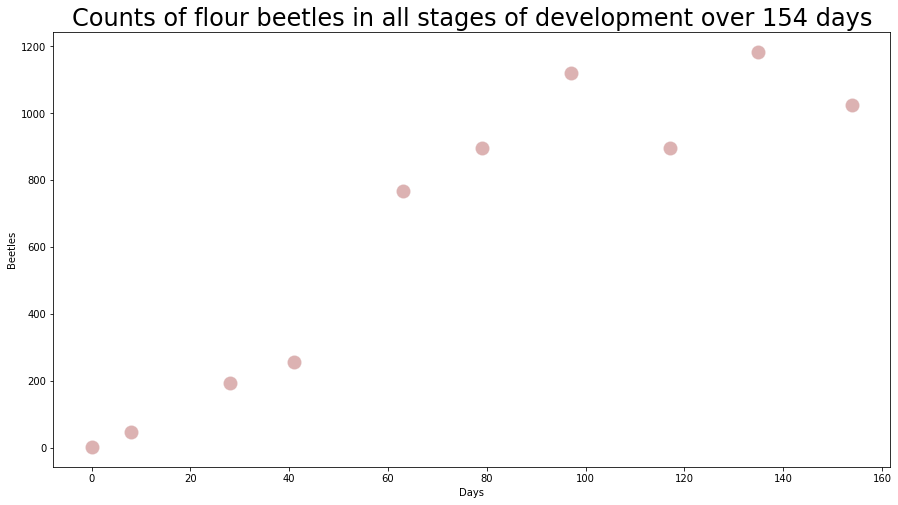

In [3]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=Data,x='Days',y='Beetles',color="darkred",alpha=0.3,s=200)
plt.title("Counts of flour beetles in all stages of development over 154 days",fontsize=24)

we need to have first and second derivative respect to $K$, $r$:

In [4]:
t = Symbol('t')
K = Symbol('K')
r = Symbol('r')
f = (K*2)/(2+(K-2)*sym.exp(-r*t))
ft=lambdify([t,K,r], f, 'numpy')

According to Table 2.3, $N_0$ is 2. Therefore, 

The first derivative respect to $K$ is:

In [5]:
f_prime_K = f.diff(K)
f_prime_K

-2*K*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2 + 2/((K - 2)*exp(-r*t) + 2)

The second derivative respect to $K$ is:

In [6]:
f_doubleprime_K=f_prime_K.diff(K)
f_doubleprime_K

4*K*exp(-2*r*t)/((K - 2)*exp(-r*t) + 2)**3 - 4*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2

The first derivative respect to $r$ is:

In [7]:
f_prime_r = f.diff(r)
f_prime_r

2*K*t*(K - 2)*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2

The second derivative respect to $r$ is:

In [8]:
f_doubleprime_r=f_prime_r.diff(r)
f_doubleprime_r

4*K*t**2*(K - 2)**2*exp(-2*r*t)/((K - 2)*exp(-r*t) + 2)**3 - 2*K*t**2*(K - 2)*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2

The second derivative respect to  $𝑟$  and $K$ is:

In [9]:
f_doubleprime_Kr=f_prime_K.diff(r)
f_doubleprime_Kr

-4*K*t*(K - 2)*exp(-2*r*t)/((K - 2)*exp(-r*t) + 2)**3 + 2*K*t*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2 + 2*t*(K - 2)*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2

In [10]:
def func(t):
    K = Symbol('K')
    r = Symbol('r')
    function=zeros(len(t),1)
    for i in range(0,len(t)):
        function[i] = (K*2)/(2+(K-2)*sym.exp(-r*t[i]))
    return function
f=func(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft=lambdify([K,r], f, 'numpy')

In [11]:
def difffunc(t):
    K = Symbol('K')
    r = Symbol('r')
    difffunction=zeros(len(t),1)
    for i in range(0,len(t)):
        difffunction[i] = (K*2*r*(K-2)*sym.exp(-r*t[i]))/(2+(K-2)*sym.exp(-r*t[i]))**2
    return difffunction
difff=difffunc(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft_prime=lambdify([K,r], difff, 'numpy')

In [12]:
def difffunc_k(t):
    K = Symbol('K')
    r = Symbol('r')
    difffunctionk=zeros(len(t),1)
    for i in range(0,len(t)):
        difffunctionk[i] = ((-K*2*sym.exp(-r*t[i]))/((2+(K-2)*sym.exp(-r*t[i]))**2))+(2/(2+(K-2)*sym.exp(-r*t[i])))
    return difffunctionk
difff_k=difffunc_k(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft_prime_k=lambdify([K,r], difff_k, 'numpy')

In [13]:
def difffunc_r(t):
    K = Symbol('K')
    r = Symbol('r')
    difffunctionr=zeros(len(t),1)
    for i in range(0,len(t)):
        difffunctionr[i] = (K*2*t[i]*(K-2)*sym.exp(-r*t[i]))/((2+(K-2)*sym.exp(-r*t[i]))**2)
    return difffunctionr
difff_r=difffunc_r(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft_prime_r=lambdify([K,r], difff_r, 'numpy')

In [14]:
A=np.column_stack((ft_prime_k(100,5), ft_prime_r(100,5)))
A.T
inv(A.T.dot(A))

array([[ 1.25000000e-01, -7.50590774e+11],
       [-7.50590774e+11,  4.05638288e+25]])

In [15]:
def Gauss_Newton(y,K_init,r_init,e,maxiter):
    K=K_init
    r=r_init
    residual=sum((y-ft(K,r))**2)
    Result = pd.DataFrame(columns=['K', 'r','Residual','SE_K','SE_r','Correlation'])
    Result.loc[0] = [K, r,residual,'nan','nan','nan']
    itr=0
    j=1
    

    while (residual[0]>e):
        x=y-ft(K,r)
        A=np.column_stack((ft_prime_k(K,r), ft_prime_r(K,r)))        
        [[K],[r]]=[[K],[r]]+inv(A.T.dot(A)).dot(A.T).dot(x)
        residual_new=sum((y-ft(K,r))**2)
        residual=residual_new
        s=residual[0]/(len(y)-2)
        cov=inv(A.T.dot(A))
        corr=cov[0][1]/(np.sqrt(cov[0][0])*np.sqrt(cov[1][1]))
        se=np.sqrt(s)*np.sqrt(inv(A.T.dot(A)).diagonal())
        print(tabulate([[itr, np.array([[K],[r]]),residual,se[0],se[1],corr]], headers=['iteration', 'K and r','Error','SE_K','SE_r','Correlation'], tablefmt='orgtbl'))

        Result.loc[j] = [K, r,residual[0],se[0],se[1],corr]
        
        #print(np.array(residual))
        #print(sqrt(s)*sqrt(inv(A.T.dot(A)).diagonal()))
        #print(np.sqrt(inv(A.T.dot(A)).diagonal()))
        
        
        #print('corr',cov[0][1]/(np.sqrt(cov[0][0])*np.sqrt(cov[1][1])))
        #print('se',se)
        

        itr+=1
        j+=1
        if itr==maxiter:
            break
    print ('The optimum is at: K=', K,'r=',r)
    print ('number of iteration is: ', itr)
    return Result, K, r


In [16]:
result,K,r=Gauss_Newton(Data[['Beetles']],200,0.5,0.001,1000)

|   iteration | K and r            |   Error |    SE_K |     SE_r |   Correlation |
|-------------+--------------------+---------+---------+----------+---------------|
|           0 | [[7.92053944e+02]  |  694134 | 104.148 | 0.804343 |     -0.044258 |
|             |  [2.31881269e-01]] |         |         |          |               |
|   iteration | K and r            |   Error |    SE_K |      SE_r |   Correlation |
|-------------+--------------------+---------+---------+-----------+---------------|
|           1 | [[9.02420443e+02]  |  191507 | 59.5852 | 0.0299915 |     -0.206449 |
|             |  [1.47186348e-01]] |         |         |           |               |
|   iteration | K and r            |   Error |    SE_K |      SE_r |   Correlation |
|-------------+--------------------+---------+---------+-----------+---------------|
|           2 | [[1.00065034e+03]  | 91162.8 | 44.8138 | 0.0110106 |     -0.188656 |
|             |  [1.25873347e-01]] |         |         |           | 

The final $k$ and $r$ are:

In [17]:
print ('The optimum is at: K=', K,'r=',r)

The optimum is at: K= 1033.5153256382757 r= 0.11795855719560162


The last 5 iterations for Gauss_Newton method is:

In [18]:
result.tail(5)

,K,r,Residual,SE_K,SE_r,Correlation
996,1033.52,0.117959,83240.5,47.8238,0.00777512,-0.342842
997,1033.52,0.117959,83240.5,47.8238,0.00777512,-0.342842
998,1033.52,0.117959,83240.5,47.8238,0.00777512,-0.342842
999,1033.52,0.117959,83240.5,47.8238,0.00777512,-0.342842
1000,1033.52,0.117959,83240.5,47.8238,0.00777512,-0.342842


Now, we can plot the ﬁtted model together with the observed data in a single plot.

In [19]:
t_plot=linspace(0,160,1000)
f_plot=func(t_plot)
K = Symbol('K')
r = Symbol('r')
ft_plot=lambdify([K,r], f_plot, 'numpy')
y1=ft_plot(1033.515326,0.117959)

Text(0, 0.5, 'Beetles')

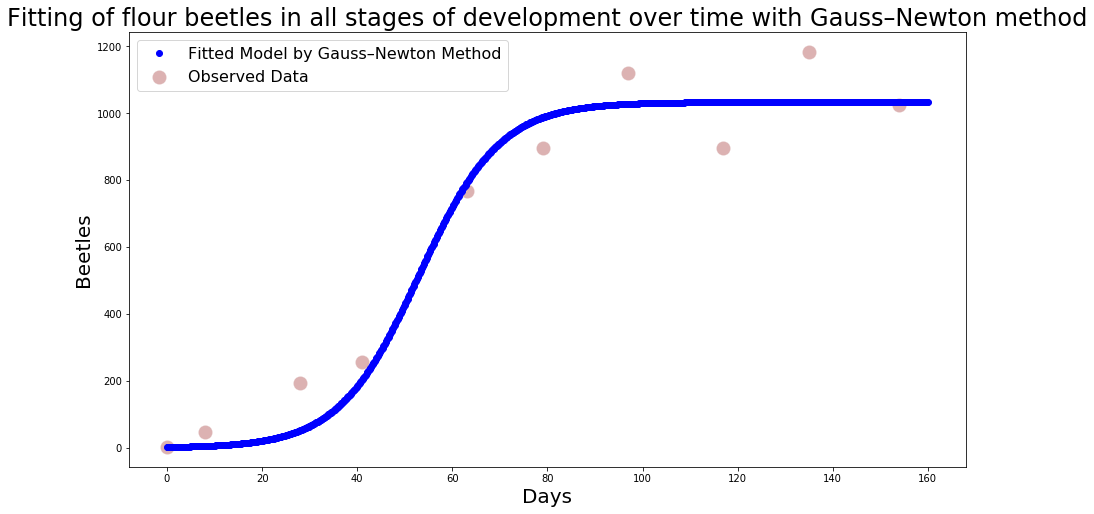

In [20]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=Data,x='Days',y='Beetles',color="darkred",alpha=0.3,s=200)
plt.title("Fitting of flour beetles in all stages of development over time with Gauss–Newton method",fontsize=24)
plt.plot(t_plot, y1, 'bo')
plt.legend(("Fitted Model by Gauss–Newton Method", "Observed Data"),fontsize=16)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Beetles',fontsize=20)

## b. Fit the logistic growth model to the ﬂour beetle data using the Newton–Raphson approach to minimize the sum of squared errors between model predictions and observed counts. 

In [21]:
def doubledifffunc_k(t):
    K = Symbol('K')
    r = Symbol('r')
    doubledifffunctionk=zeros(len(t),1)
    for i in range(0,len(t)):
        doubledifffunctionk[i] = (K*4*sym.exp(-2*r*t[i]))/(((K-2)*sym.exp(-r*t[i])+2)**3)-(4*sym.exp(-r*t[i]))/(((K-2)*sym.exp(-r*t[i]))+2)**2
    return doubledifffunctionk
doubledifff_k=doubledifffunc_k(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft_doubleprime_k=lambdify([K,r], doubledifff_k, 'numpy')

In [22]:
t = Symbol('t')
K = Symbol('K')
r = Symbol('r')
f = (K*2)/(2+(K-2)*sym.exp(-r*t))
ft=lambdify([t,K,r], f, 'numpy')

In [23]:
f_prime_r = f.diff(r)
f_doubleprime_r=f_prime_r.diff(r)
f_firstder_r=lambdify([t,K,r], f_prime_r, 'numpy')
f_secder_r=lambdify([t,K,r], f_doubleprime_r, 'numpy')

In [24]:
f_prime_r

2*K*t*(K - 2)*exp(-r*t)/((K - 2)*exp(-r*t) + 2)**2

In [25]:
f_prime_K = f.diff(K)
f_doubleprime_K=f_prime_K.diff(K)
f_firstder_K=lambdify([t,K,r], f_prime_K, 'numpy')
f_secder_K=lambdify([t,K,r], f_doubleprime_K, 'numpy')

In [26]:
f_doubleprime_Kr=f_prime_K.diff(r)
f_secder_Kr=lambdify([t,K,r], f_doubleprime_Kr, 'numpy')

In [27]:
def g(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=(y[i]-ft(t[i],K,r))**2
    return g

In [28]:
def gprime_r(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-ft(t[i],K,r))*f_firstder_r(t[i],K,r)
    return g    

In [29]:
def gprime_K(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-ft(t[i],K,r))*f_firstder_K(t[i],K,r)
    return g    

In [30]:
def gdoubleprime_r(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-ft(t[i],K,r))*f_secder_r(t[i],K,r)+2*((f_firstder_r(t[i],K,r))**2)
    return g    

In [31]:
def gdoubleprime_K(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-ft(t[i],K,r))*f_secder_K(t[i],K,r)+2*((f_firstder_K(t[i],K,r))**2)
    return g    

In [32]:
def gdoubleprime_Kr(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-ft(t[i],K,r))*f_secder_Kr(t[i],K,r)+2*f_firstder_K(t[i],K,r)*f_firstder_r(t[i],K,r)
    return g    

In [33]:
def Newton_Rapson(y,t,K_init,r_init,e,maxiter):
    itr=0
    j=2
    K=K_init
    r=r_init
    residual=g(y,t,K,r)
    Result = pd.DataFrame(columns=['K', 'r','Residual','Hessian first col.','Hessian second col.','SE_K','SE_r','Correlation'])
    Result.loc[0] = [K, r,residual, gdoubleprime_K(y,t,K,r),gdoubleprime_Kr(y,t,K,r),'nan','nan','nan']
    Result.loc[1] = ['nan', 'nan','nan', gdoubleprime_Kr(y,t,K,r),gdoubleprime_r(y,t,K,r),'nan','nan','nan']
    
    hessian_matrix=[[gdoubleprime_K(y,t,K,r),gdoubleprime_Kr(y,t,K,r)],[gdoubleprime_Kr(y,t,K,r),gdoubleprime_r(y,t,K,r)]]

    while (residual>e):
        delta=[[gprime_K(y,t,K,r)],[gprime_r(y,t,K,r)]]

        [[K],[r]] = [[K],[r]] - inv(hessian_matrix).dot(delta)
        hessian_matrix=[[gdoubleprime_K(y,t,K,r),gdoubleprime_Kr(y,t,K,r)],[gdoubleprime_Kr(y,t,K,r),gdoubleprime_r(y,t,K,r)]]
        #I=-1*hessian_matrix
        #cov=inv(I)
        cov=(inv(hessian_matrix))
        corr=cov[0][1]/(np.sqrt(cov[0][0])*np.sqrt(cov[1][1]))
        seK=np.sqrt(cov[0][0])
        ser=np.sqrt(cov[1][1])
        #print('corr',cov[0][1]/(np.sqrt(cov[0][0])*np.sqrt(cov[1][1])))
        #print('seK',np.sqrt(cov[0][0]))
        #print('ser',np.sqrt(cov[1][1]))
        residual_new=g(y,t,K,r)
        residual=residual_new
        print(tabulate([[itr, np.array([[K],[r]]), np.array(hessian_matrix),seK,ser,corr]], headers=['iteration', 'K and r','Hessian Matrix','SE_K','SE_r','Correlation'], tablefmt='orgtbl'))
        Result.loc[j] = [K, r,residual, gdoubleprime_K(y,t,K,r),gdoubleprime_Kr(y,t,K,r),seK,ser,corr]
        Result.loc[j+1] = ['nan', 'nan','nan',  gdoubleprime_Kr(y,t,K,r),gdoubleprime_r(y,t,K,r),'nan','nan','nan']

        itr+=1
        j+=2
        if itr==maxiter:
            break
    print ('The optimum is at: K=', K,'r=',r)
    print ('number of iteration is: ', itr)
    return Result,K,r

In [34]:
result_NR,K_NR,r_NR=Newton_Rapson(Data['Beetles'],Data['Days'],200,0.5,0.001,1000)

|   iteration | K and r            | Hessian Matrix                    |     SE_K |        SE_r |   Correlation |
|-------------+--------------------+-----------------------------------+----------+-------------+---------------|
|           0 | [[7.95377545e+02]  | [[1.17130135e+01 1.06403977e+04]  | 0.302053 | 8.42724e-05 |      -0.25345 |
|             |  [1.45656031e-01]] |  [1.06403977e+04 1.50474490e+08]] |          |             |               |
|   iteration | K and r            | Hessian Matrix                    |    SE_K |       SE_r |   Correlation |
|-------------+--------------------+-----------------------------------+---------+------------+---------------|
|           1 | [[1.01029588e+03]  | [[1.03848816e+01 2.16719749e+04]  | 0.33787 | 6.4043e-05 |     -0.395566 |
|             |  [1.18887738e-01]] |  [2.16719749e+04 2.89039405e+08]] |         |            |               |
|   iteration | K and r            | Hessian Matrix                    |     SE_K |        SE_r 

The final $k$ and $r$ are:

In [35]:
print ('The optimum is at: K=', K_NR,'r=',r_NR)

The optimum is at: K= 1033.5153256382757 r= 0.11795855719560162


The last 5 iterations for Gauss_Newton method is:

In [36]:
result_NR.tail(10)

,K,r,Residual,Hessian first col.,Hessian second col.,SE_K,SE_r,Correlation
1992,1033.52,0.117959,83240.5,10.293105,2.326315e+04,0.342438,6.27478e-05,-0.414132
1993,nan,nan,nan,23263.148090,3.065581e+08,nan,nan,nan
1994,1033.52,0.117959,83240.5,10.293105,2.326315e+04,0.342438,6.27478e-05,-0.414132
1995,nan,nan,nan,23263.148090,3.065581e+08,nan,nan,nan
1996,1033.52,0.117959,83240.5,10.293105,2.326315e+04,0.342438,6.27478e-05,-0.414132
1997,nan,nan,nan,23263.148090,3.065581e+08,nan,nan,nan
1998,1033.52,0.117959,83240.5,10.293105,2.326315e+04,0.342438,6.27478e-05,-0.414132
1999,nan,nan,nan,23263.148090,3.065581e+08,nan,nan,nan
2000,1033.52,0.117959,83240.5,10.293105,2.326315e+04,0.342438,6.27478e-05,-0.414132
2001,nan,nan,nan,23263.148090,3.065581e+08,nan,nan,nan


Now, we can plot the ﬁtted model together with the observed data in a single plot.

Text(0, 0.5, 'Beetles')

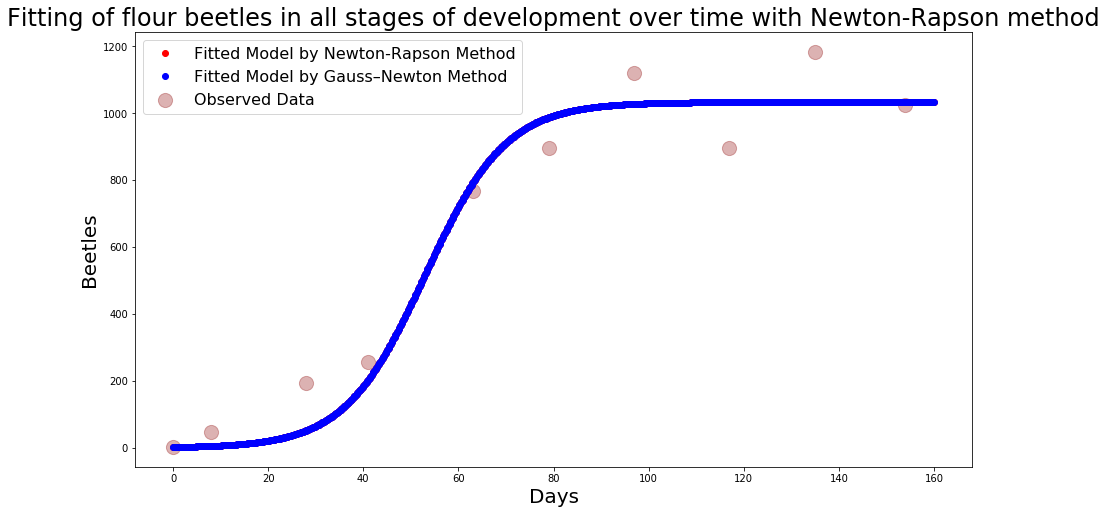

In [37]:
plt.figure(figsize=(15,8))
plt.scatter(data=Data,x='Days',y='Beetles',color="darkred",alpha=0.3,s=200)
plt.title("Fitting of flour beetles in all stages of development over time with Newton-Rapson method",fontsize=24)
plt.plot(t_plot, ft(t_plot,1033.5153256382757, 0.11795855719560162), 'ro')
plt.plot(t_plot, y1, 'bo')
plt.legend(("Fitted Model by Newton-Rapson Method", "Fitted Model by Gauss–Newton Method","Observed Data"),fontsize=16)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Beetles',fontsize=20)

As we can see in the above graph, the fitted model by Newton-Rapson and Gauss-Newton are completely same. 

## c. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $logNt$ are independent and normally distributed with mean $logf(t)$ and variance $\sigma^2$. Find the MLEs under thisassumption,using both the Gauss–Newton and the Newton–Raphson methods. Provide standard errors for your parameter estimates, and an estimate of the correlation between them. Comment. 

\begin{equation*}
log N_t \sim N(log f(t), \sigma^2) 
\end{equation*}

\begin{equation*}
log f(t) = log K +log N_0 - log[N_0+(K-N_0) e^{-rt}] 
\end{equation*}

\begin{equation*}
y_t= log N_t  
\end{equation*}

\begin{equation*}
L(K,r)= \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}}\exp(-\frac{[y_{t_{i}}-log f(t_i)]^2}{2\sigma^2})
\end{equation*}

\begin{equation*}
l(K,r)=log L(k,r)=\sum_{i = 1}^{n} log(\frac{1}{\sqrt{2 \pi \sigma^2}}) - \frac{1}{2\sigma^2}\sum_{i = 1}^{n} [y_{t_{i}}-log f(t_i)]^2
\end{equation*}

l is a function of K and r. To find the maximum lokelihood, we need to minimize the $\sum_{i = 1}^{n} [y_{t_{i}}-log f(t_i)]^2$

In [38]:
Data['log(N_t)']=np.log(Data['Beetles'])
Data

,Days,Beetles,log(N_t)
0,0,2,0.693147
1,8,47,3.850148
2,28,192,5.257495
3,41,256,5.545177
4,63,768,6.643790
5,79,896,6.797940
6,97,1120,7.021084
7,117,896,6.797940
8,135,1184,7.076654
9,154,1024,6.931472


## Gauss-Newton

In [39]:
def func(t):
    K = Symbol('K')
    r = Symbol('r')
    function=zeros(len(t),1)
    for i in range(0,len(t)):
        function[i] = log(K)+log(2)-log(2+(K-2)*sym.exp(-r*t[i]))
    return function
f=func(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft=lambdify([K,r], f, 'numpy')

In [40]:
def difffunc_k(t):
    K = Symbol('K')
    r = Symbol('r')
    difffunctionk=zeros(len(t),1)
    for i in range(0,len(t)):
        difffunctionk[i] = -(exp(-r*t[i])/((K-2)*exp(-r*t[i])+2))+1/K
    return difffunctionk
difff_k=difffunc_k(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft_prime_k=lambdify([K,r], difff_k, 'numpy')

In [41]:
def difffunc_r(t):
    K = Symbol('K')
    r = Symbol('r')
    difffunctionr=zeros(len(t),1)
    for i in range(0,len(t)):
        difffunctionr[i] = t[i]*(K-2)*exp(-r*t[i])/((K-2)*sym.exp(-r*t[i])+2)
    return difffunctionr
difff_r=difffunc_r(Data['Days'])
K = Symbol('K')
r = Symbol('r')
ft_prime_r=lambdify([K,r], difff_r, 'numpy')

In [42]:
A=np.column_stack((ft_prime_k(100,5), ft_prime_r(100,5)))
A.T
inv(A.T.dot(A))

array([[ 1.25000000e+03, -7.50590774e+15],
       [-7.50590774e+15,  4.05638288e+29]])

In [43]:
result_GNlog,K_GNlog,r_GNlog=Gauss_Newton(Data[['log(N_t)']],1000,0.5,0.001,1000)

|   iteration | K and r            |   Error |    SE_K |      SE_r |   Correlation |
|-------------+--------------------+---------+---------+-----------+---------------|
|           0 | [[6.01451636e+02]  | 3.53085 | 234.899 | 0.0921852 |    -0.0347821 |
|             |  [4.02288386e-01]] |         |         |           |               |
|   iteration | K and r            |   Error |    SE_K |      SE_r |   Correlation |
|-------------+--------------------+---------+---------+-----------+---------------|
|           1 | [[6.68167222e+02]  | 3.43271 | 139.381 | 0.0887409 |    -0.0312718 |
|             |  [4.00798949e-01]] |         |         |           |               |
|   iteration | K and r            |   Error |    SE_K |      SE_r |   Correlation |
|-------------+--------------------+---------+---------+-----------+---------------|
|           2 | [[6.72070895e+02]  | 3.43244 | 154.848 | 0.0879726 |    -0.0293295 |
|             |  [4.00502373e-01]] |         |         |         

The final $k$ and $r$ are:

In [44]:
print ('The optimum is at: K=', K_GNlog,'r=',r_GNlog)

The optimum is at: K= 672.0907891427541 r= 0.40046090005088


The last 5 iterations for Gauss_Newton method is:

In [45]:
result_GNlog.tail(5)

,K,r,Residual,SE_K,SE_r,Correlation
996,672.091,0.400461,3.43244,155.759,0.0879202,-0.0292281
997,672.091,0.400461,3.43244,155.759,0.0879202,-0.0292281
998,672.091,0.400461,3.43244,155.759,0.0879202,-0.0292281
999,672.091,0.400461,3.43244,155.759,0.0879202,-0.0292281
1000,672.091,0.400461,3.43244,155.759,0.0879202,-0.0292281


Now, we can plot the ﬁtted model together with the observed data in a single plot.

In [46]:
t_plot=linspace(0,160,1000)
f_plot=func(t_plot)
K = Symbol('K')
r = Symbol('r')
ft_plot=lambdify([K,r], f_plot, 'numpy')
y1=ft_plot(672.0907891427541,0.40046090005088)

Text(0, 0.5, 'Beetles')

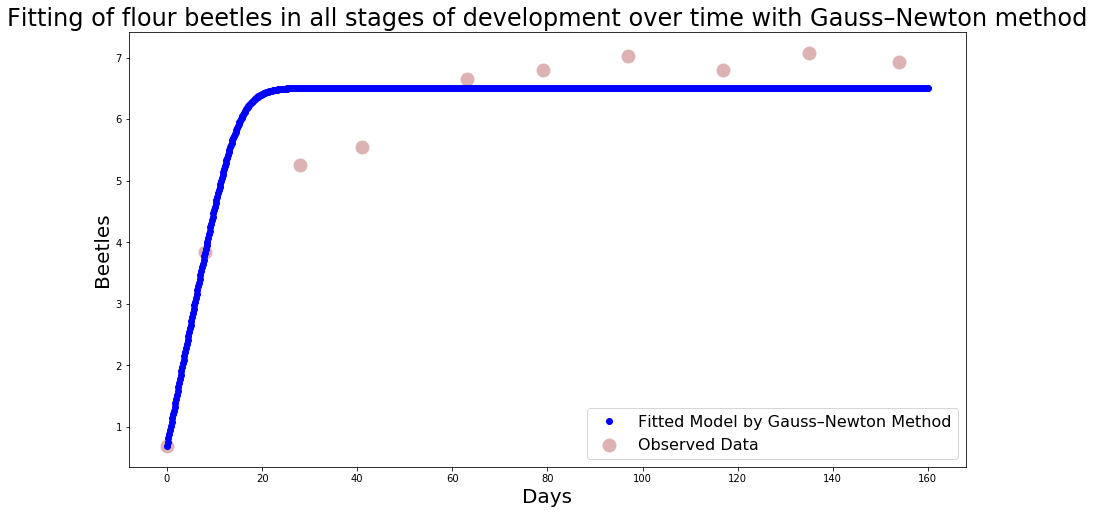

In [47]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=Data,x='Days',y='log(N_t)',color="darkred",alpha=0.3,s=200)
plt.title("Fitting of flour beetles in all stages of development over time with Gauss–Newton method",fontsize=24)
plt.plot(t_plot, y1, 'bo')
plt.legend(("Fitted Model by Gauss–Newton Method", "Observed Data"),fontsize=16)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Beetles',fontsize=20)

## Newton-Raphson

In [48]:
t = Symbol('t')
K = Symbol('K')
r = Symbol('r')
logf = log(K)+log(2)-log(2+(K-2)*sym.exp(-r*t))
logft=lambdify([t,K,r], logf, 'numpy')

In [49]:
logf_prime_r = logf.diff(r)
logf_doubleprime_r=logf_prime_r.diff(r)
logf_firstder_r=lambdify([t,K,r], logf_prime_r, 'numpy')
logf_secder_r=lambdify([t,K,r], logf_doubleprime_r, 'numpy')

In [50]:
logf_prime_r

t*(K - 2)*exp(-r*t)/((K - 2)*exp(-r*t) + 2)

In [51]:
logf_prime_K = logf.diff(K)
logf_doubleprime_K=logf_prime_K.diff(K)
logf_firstder_K=lambdify([t,K,r], logf_prime_K, 'numpy')
logf_secder_K=lambdify([t,K,r], logf_doubleprime_K, 'numpy')

In [52]:
logf_prime_K

-exp(-r*t)/((K - 2)*exp(-r*t) + 2) + 1/K

In [53]:
logf_doubleprime_Kr=logf_prime_K.diff(r)
logf_secder_Kr=lambdify([t,K,r], logf_doubleprime_Kr, 'numpy')

In [54]:
def g(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=(y[i]-logft(t[i],K,r))**2
    return g

In [55]:
def gprime_r(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-logft(t[i],K,r))*logf_firstder_r(t[i],K,r)
    return g    

In [56]:
def gprime_K(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-logft(t[i],K,r))*logf_firstder_K(t[i],K,r)
    return g    

In [57]:
def gdoubleprime_r(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-logft(t[i],K,r))*logf_secder_r(t[i],K,r)+2*((logf_firstder_r(t[i],K,r))**2)
    return g    

In [58]:
def gdoubleprime_K(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-logft(t[i],K,r))*logf_secder_K(t[i],K,r)+2*((logf_firstder_K(t[i],K,r))**2)
    return g    

In [59]:
def gdoubleprime_Kr(y,t,K,r):
    g=0
    for i in range (0,len(t)):
        g+=-2*(y[i]-logft(t[i],K,r))*logf_secder_Kr(t[i],K,r)+2*logf_firstder_K(t[i],K,r)*logf_firstder_r(t[i],K,r)
    return g    

In [60]:
result_NRlog,K_NRlog,r_NRlog=Newton_Rapson(Data['log(N_t)'],Data['Days'],200,0.5,0.001,1000)

|   iteration | K and r          | Hessian Matrix                    |    SE_K |      SE_r |   Correlation |
|-------------+------------------+-----------------------------------+---------+-----------+---------------|
|           0 | [[313.7338036 ]  | [[2.87748778e-04 5.60333178e-03]  | 58.9828 | 0.0989909 |    -0.0326816 |
|             |  [  0.32481905]] |  [5.60333178e-03 1.02158286e+02]] |         |           |               |
|   iteration | K and r            | Hessian Matrix                    |    SE_K |     SE_r |   Correlation |
|-------------+--------------------+-----------------------------------+---------+----------+---------------|
|           1 | [[4.48557561e+02]  | [[1.11675981e-04 3.68616179e-03]  | 94.6858 | 0.100116 |    -0.0349006 |
|             |  [4.04443868e-01]] |  [3.68616179e-03 9.98904859e+01]] |         |          |               |
|   iteration | K and r            | Hessian Matrix                    |    SE_K |      SE_r |   Correlation |
|------------

The final $k$ and $r$ are:

In [61]:
print ('The optimum is at: K=', K_NRlog,'r=',r_NRlog)

The optimum is at: K= 672.0907891427541 r= 0.40046090005088


The last 5 iterations for Gauss_Newton method is:

In [62]:
result_NRlog.tail(10)

,K,r,Residual,Hessian first col.,Hessian second col.,SE_K,SE_r,Correlation
1992,672.091,0.400461,3.43244,0.000035,0.002271,168.238,0.0988794,-0.0377286
1993,nan,nan,nan,0.002271,102.425202,nan,nan,nan
1994,672.091,0.400461,3.43244,0.000035,0.002271,168.238,0.0988794,-0.0377286
1995,nan,nan,nan,0.002271,102.425202,nan,nan,nan
1996,672.091,0.400461,3.43244,0.000035,0.002271,168.238,0.0988794,-0.0377286
1997,nan,nan,nan,0.002271,102.425202,nan,nan,nan
1998,672.091,0.400461,3.43244,0.000035,0.002271,168.238,0.0988794,-0.0377286
1999,nan,nan,nan,0.002271,102.425202,nan,nan,nan
2000,672.091,0.400461,3.43244,0.000035,0.002271,168.238,0.0988794,-0.0377286
2001,nan,nan,nan,0.002271,102.425202,nan,nan,nan


Now, we can plot the ﬁtted model together with the observed data in a single plot.

Text(0, 0.5, 'Beetles')

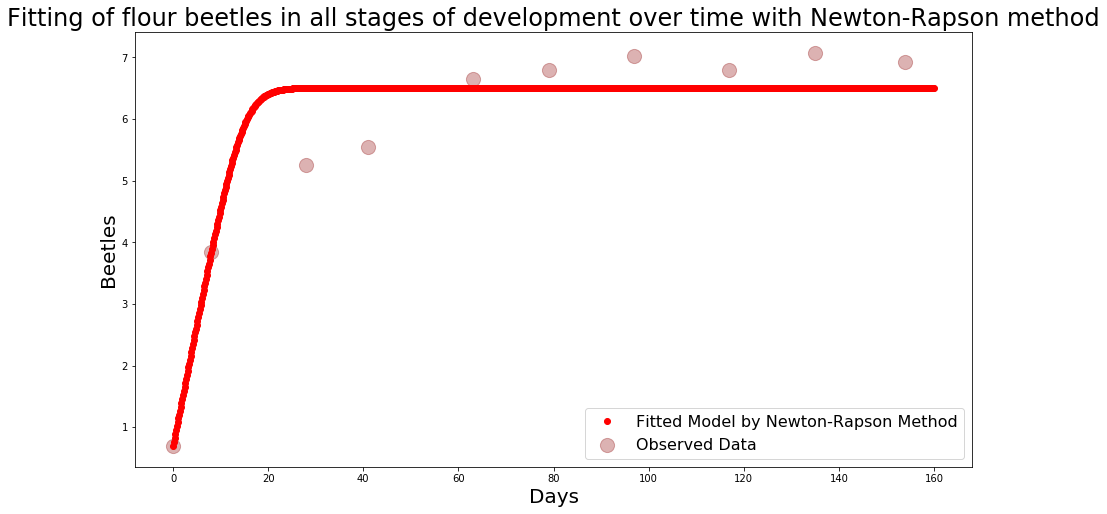

In [63]:
plt.figure(figsize=(15,8))
plt.scatter(data=Data,x='Days',y='log(N_t)',color="darkred",alpha=0.3,s=200)
plt.title("Fitting of flour beetles in all stages of development over time with Newton-Rapson method",fontsize=24)
plt.plot(t_plot, logft(t_plot,672.0907891427541, 0.40046090005088), 'ro')
plt.legend(("Fitted Model by Newton-Rapson Method", "Observed Data"),fontsize=16)
plt.xlabel('Days',fontsize=20)
plt.ylabel('Beetles',fontsize=20)

## Last part of question: Provide standard errors for your parameter estimates, and an estimate of the correlation between them. Comment.

To find the standard error, first we need to find covariance matrix:

In $\textbf{Gauss-Newton}$ method:

\begin{equation*}
Covariance\ matrix=[A^T  A]^{-1}
\end{equation*}

In $\textbf{Newton-Raphson}$ method covariance matrix can be find from inverse of Fisher matrix. An estimation of Fisher matrix is Hessain matrix.

\begin{equation*}
I(K,r) (Fisher matrix)=-H(K,r) (Hessian matrix)
\end{equation*}

\begin{equation*}
Covariance\ matrix=[I(K,r)]^{-1}
\end{equation*}

The diagonal of covariance matrix is variance of each parameter. This can be a good estimation for standard error of parameters. 

Correlation between $K$ and $r$ can be find from following equation:

\begin{equation*}
Correlation=\frac{covariance(K,r)}{\sqrt{varance(K)}\sqrt{varance(r)}}
\end{equation*}

According to result, when we use normal distribution, the standard error and $K$ is more than $r$. The correlation between $K$ and $r$ is around 0.03 which shows they are uncorrelative. 

# 2. Reproduce the solution to Example 4.2. That is, present the output of your code in the format of Table 4.1.


According to Example 4.2, We Suppose the observed phenotype counts are $n_C =85$, $n_I =196$, and $n_T =341$. Also we consider initial values for n and p:

In [64]:
x = np.array([85, 196, 341])
n = np.zeros(6)
p = np.repeat((1/3), 3)

First we need to do E-step. Therefore, we need to write the Expectation Function:

In [65]:
def Expectation(x, p):
    cc = (x[0]*(p[0]**2))/((p[0]**2)+2*p[0]*p[1]+2*p[0]*p[2])
    ci = (2*x[0]*p[0]*p[1])/((p[0]**2)+2*p[0]*p[1]+2*p[0]*p[2])
    ct = (2*x[0]*p[0]*p[2])/((p[0]**2)+2*p[0]*p[1]+2*p[0]*p[2])
    ii = (x[1]*(p[1]**2))/((p[1]**2)+2*p[1]*p[2])
    it = (2*x[1]*p[1]*p[2])/((p[1]**2)+2*p[1]*p[2])
    n = np.array([cc, ci, ct, ii, it, x[2]])
    return n

Second we need to do M-step. Therefore, we need to write the Maximization Function:

In [66]:
def Maximization(x, n):
    c = (2*n[0]+n[1]+n[2])/(2*sum(x))
    i = (2*n[3]+n[4]+n[1])/(2*sum(x))
    t = (2*n[5]+n[2]+n[4])/(2*sum(x))
    p = np.array([c, i, t])
    return p

Now, we can define the EM function:

In [67]:
def EM(x,p,e,maxiter):
    pc_arrey = []
    pi_arrey = []
    for i in range(maxiter):
        p0 = p
        pc_arrey.append(p0[0])
        pi_arrey.append(p0[1])
        if i == 0:
            print(tabulate([[i, p0[0], p0[1], 0, 0, 0]],headers = ['t', 'Pc(t)', 'Pi(t)', 'R(t)', 'Dc(t)', 'Di(t)'],tablefmt='orgtbl'))        
       
        n = Expectation(x,p)
        p = Maximization(x,n)
        R = LA.norm((p[0:2] - p0[0:2]), 2) / LA.norm(p0[0:2], 2)
        Dc = (p[0] - 0.0708369) / (p0[0] - 0.0708369)
        Di = (p[1] - 0.188737) / (p0[1] - 0.188737)
        print(tabulate([[i+1, p[0], p[1], R, Dc, Di]],headers = ['t', 'Pc(t)', 'Pi(t)', 'R(t)', 'Dc(t)', 'Di(t)'],tablefmt='orgtbl'))

        if R < e:
            break;


In [68]:
EM(x,p,0.000001,60)

|   t |    Pc(t) |    Pi(t) |   R(t) |   Dc(t) |   Di(t) |
|-----+----------+----------+--------+---------+---------|
|   0 | 0.333333 | 0.333333 |      0 |       0 |       0 |
|   t |     Pc(t) |    Pi(t) |     R(t) |     Dc(t) |    Di(t) |
|-----+-----------+----------+----------+-----------+----------|
|   1 | 0.0819936 | 0.237406 | 0.570685 | 0.0425022 | 0.336587 |
|   t |    Pc(t) |   Pi(t) |     R(t) |     Dc(t) |    Di(t) |
|-----+----------+---------+----------+-----------+----------|
|   2 | 0.071249 | 0.19787 | 0.163121 | 0.0369333 | 0.187647 |
|   t |    Pc(t) |   Pi(t) |     R(t) |     Dc(t) |    Di(t) |
|-----+----------+---------+----------+-----------+----------|
|   3 | 0.070852 | 0.19036 | 0.035756 | 0.0367456 | 0.177756 |
|   t |     Pc(t) |    Pi(t) |       R(t) |     Dc(t) |    Di(t) |
|-----+-----------+----------+------------+-----------+----------|
|   4 | 0.0708375 | 0.189023 | 0.00658604 | 0.0372312 | 0.175997 |
|   t |     Pc(t) |    Pi(t) |       R(t) |     D